In [ ]:
import cv2
import numpy as np
import vehicles
import time

cnt_up=0
cnt_down=0

cap=cv2.VideoCapture("surveillance.m4v")

#Get width and height of video

w=cap.get(3)
h=cap.get(4)
frameArea=h*w
areaTH=frameArea/400

#Lines
line_up=int(2*(h/5))
line_down=int(3*(h/5))

up_limit=int(1*(h/5))
down_limit=int(4*(h/5))

print("Red line y:",str(line_down))
print("Blue line y:",str(line_up))
line_down_color=(255,0,0)
line_up_color=(255,0,255)
pt1 =  [0, line_down]
pt2 =  [w, line_down]
pts_L1 = np.array([pt1,pt2], np.int32)
pts_L1 = pts_L1.reshape((-1,1,2))
pt3 =  [0, line_up]
pt4 =  [w, line_up]
pts_L2 = np.array([pt3,pt4], np.int32)
pts_L2 = pts_L2.reshape((-1,1,2))

pt5 =  [0, up_limit]
pt6 =  [w, up_limit]
pts_L3 = np.array([pt5,pt6], np.int32)
pts_L3 = pts_L3.reshape((-1,1,2))
pt7 =  [0, down_limit]
pt8 =  [w, down_limit]
pts_L4 = np.array([pt7,pt8], np.int32)
pts_L4 = pts_L4.reshape((-1,1,2))

#Background Subtractor
fgbg=cv2.createBackgroundSubtractorMOG2(detectShadows=True)

#Kernals
kernalOp = np.ones((3,3),np.uint8)
kernalOp2 = np.ones((5,5),np.uint8)
kernalCl = np.ones((11,11),np.uint8)


font = cv2.FONT_HERSHEY_SIMPLEX
cars = []
max_p_age = 5
pid = 1


while(cap.isOpened()):
    ret,frame=cap.read()
    for i in cars:
        i.age_one()
    fgmask=fgbg.apply(frame)
    fgmask2=fgbg.apply(frame)

    if ret==True:

        #Binarization
        ret,imBin=cv2.threshold(fgmask,200,255,cv2.THRESH_BINARY)
        ret,imBin2=cv2.threshold(fgmask2,200,255,cv2.THRESH_BINARY)
        
        #OPening i.e First Erode the dilate
        mask=cv2.morphologyEx(imBin,cv2.MORPH_OPEN,kernalOp)
        mask2=cv2.morphologyEx(imBin2,cv2.MORPH_CLOSE,kernalOp)

        #Closing i.e First Dilate then Erode
        mask=cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernalCl)
        mask2=cv2.morphologyEx(mask2,cv2.MORPH_CLOSE,kernalCl)


        #Find Contours
        countours0,hierarchy=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        for cnt in countours0:
            area=cv2.contourArea(cnt)
            print(area)
            if area>areaTH:
                ####Tracking######
                m=cv2.moments(cnt)
                cx=int(m['m10']/m['m00'])
                cy=int(m['m01']/m['m00'])
                x,y,w,h=cv2.boundingRect(cnt)

                new=True
                if cy in range(up_limit,down_limit):
                    for i in cars:
                        if abs(x - i.getX()) <= w and abs(y - i.getY()) <= h:
                            new = False
                            i.updateCoords(cx, cy)

                            if i.going_UP(line_down,line_up)==True:
                                cnt_up+=1
                                print("ID:",i.getId(),'crossed going up at', time.strftime("%c"))
                            elif i.going_DOWN(line_down,line_up)==True:
                                cnt_down+=1
                                print("ID:", i.getId(), 'crossed going up at', time.strftime("%c"))
                            break
                        if i.getState()=='1':
                            if i.getDir()=='down'and i.getY()>down_limit:
                                i.setDone()
                            elif i.getDir()=='up'and i.getY()<up_limit:
                                i.setDone()
                        if i.timedOut():
                            index=cars.index(i)
                            cars.pop(index)
                            del i

                    if new==True: #If nothing is detected,create new
                        p=vehicles.Car(pid,cx,cy,max_p_age)
                        cars.append(p)
                        pid+=1

                cv2.circle(frame,(cx,cy),5,(0,0,255),-1)
                img=cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)

        for i in cars:
            cv2.putText(frame, str(i.getId()), (i.getX(), i.getY()), font, 0.3, i.getRGB(), 1, cv2.LINE_AA)




        str_up='UP: '+str(cnt_up)
        str_down='DOWN: '+str(cnt_down)
        frame=cv2.polylines(frame,[pts_L1],False,line_down_color,thickness=2)
        frame=cv2.polylines(frame,[pts_L2],False,line_up_color,thickness=2)
        frame=cv2.polylines(frame,[pts_L3],False,(255,255,255),thickness=1)
        frame=cv2.polylines(frame,[pts_L4],False,(255,255,255),thickness=1)
        
        cv2.putText(frame, str_up, (10, 40), font, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(frame, str_up, (10, 40), font, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
        cv2.putText(frame, str_down, (10, 90), font, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(frame, str_down, (10, 90), font, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
        
        cv2.imshow('Frame',frame)

        if cv2.waitKey(1)&0xff==ord('q'):
            break

    else:
        break

cap.release()
cv2.destroyAllWindows()

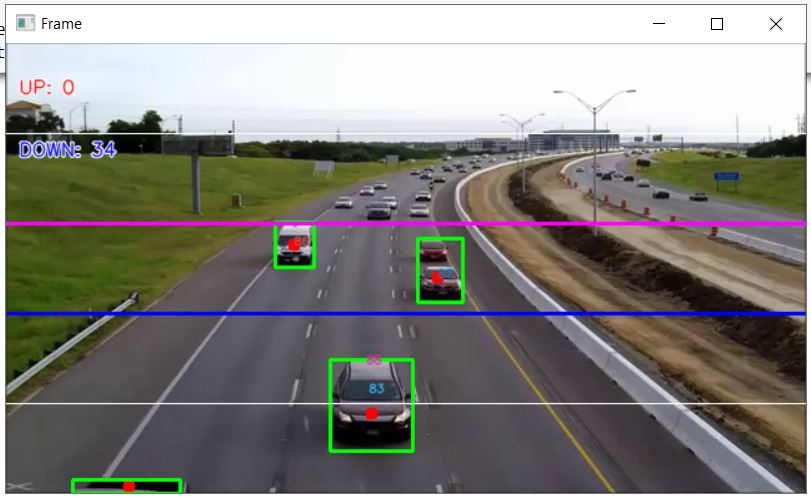